Epoch 1/15
740/740 [==============================] - 8s 9ms/step - loss: 0.0010 - mean_absolute_error: 0.0197 - val_loss: 5.1268e-04 - val_mean_absolute_error: 0.0144
Epoch 2/15
740/740 [==============================] - 7s 10ms/step - loss: 7.1838e-04 - mean_absolute_error: 0.0157 - val_loss: 5.2736e-04 - val_mean_absolute_error: 0.0141
Epoch 3/15
740/740 [==============================] - 7s 9ms/step - loss: 6.9664e-04 - mean_absolute_error: 0.0154 - val_loss: 4.9863e-04 - val_mean_absolute_error: 0.0144
Epoch 4/15
740/740 [==============================] - 8s 10ms/step - loss: 6.8029e-04 - mean_absolute_error: 0.0151 - val_loss: 4.8963e-04 - val_mean_absolute_error: 0.0143
Epoch 5/15
740/740 [==============================] - 9s 12ms/step - loss: 6.7659e-04 - mean_absolute_error: 0.0152 - val_loss: 5.2764e-04 - val_mean_absolute_error: 0.0140
Epoch 6/15
740/740 [==============================] - 9s 12ms/step - loss: 6.6730e-04 - mean_absolute_error: 0.0150 - val_loss: 5.0400e-04 - 

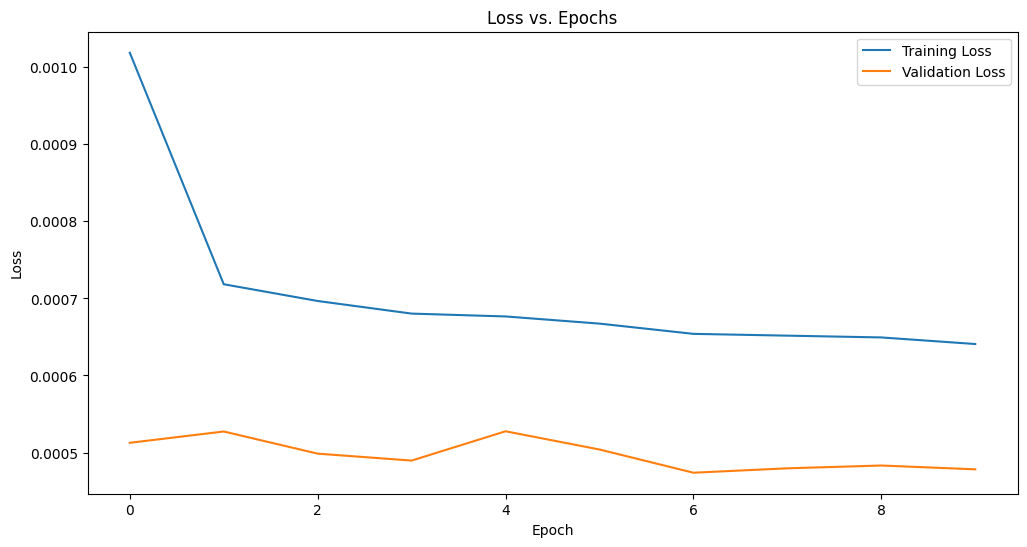

93/93 [==============================] - 1s 4ms/step
Mean Squared Error on Test Set: 0.0004
Descaled Mean Squared Error on Test Set: 28361320806.8928
Descaled Mean Absolute Error on Test Set: 107465.5841


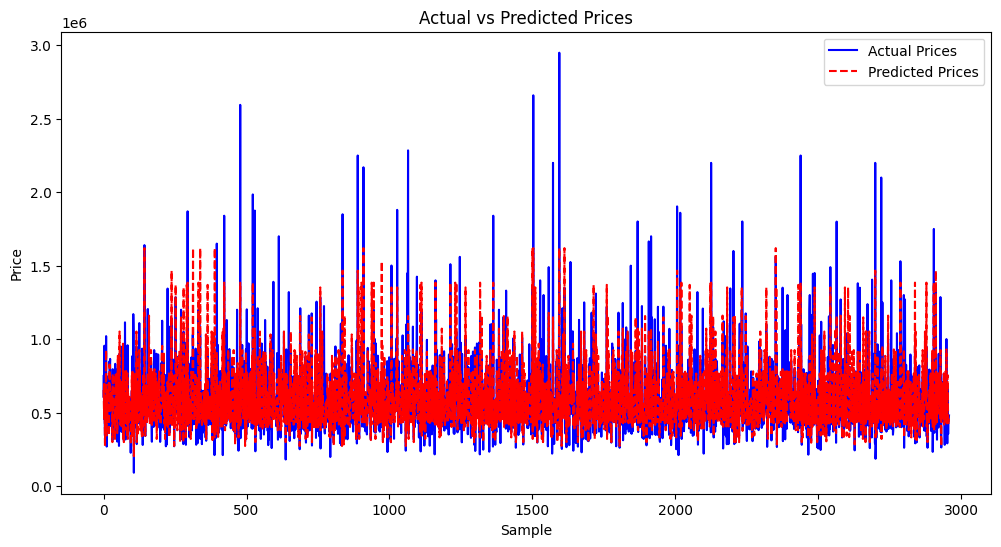

In [2]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 1.Data Preparation
url = 'https://raw.githubusercontent.com/cyustes/DeepLearning/main/raw_sales.csv'
response = requests.get(url)
csv_data = StringIO(response.text)
data = pd.read_csv(csv_data, delimiter=';', encoding='utf-8')

# One-hot encoding for 'propertyType' column
if 'propertyType' in data.columns:
    encoder = OneHotEncoder()
    propertyType_encoded = encoder.fit_transform(data[['propertyType']])
    feature_names = encoder.get_feature_names_out(['propertyType'])
    data = pd.concat([data, pd.DataFrame(propertyType_encoded.toarray(), columns=feature_names)], axis=1)
    data.drop('propertyType', axis=1, inplace=True)

# One-hot encoding for 'postcode' column
if 'postcode' in data.columns:
    encoder = OneHotEncoder()
    postCode_encoded = encoder.fit_transform(data[['postcode']])
    postcode_names = encoder.get_feature_names_out(['postcode'])
    data = pd.concat([data, pd.DataFrame(postCode_encoded.toarray(), columns=postcode_names)], axis=1)
    data.drop('postcode', axis=1, inplace=True)

data = data.drop(data.columns[0], axis=1)

# MinMaxScaler for normalization
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

X = data_scaled[:, 1:]
y = data_scaled[:, 0]

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

# 2.LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='linear'))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 3.Training and Validation
num_epochs = 15
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_reshaped, y_train, epochs=num_epochs, batch_size=32,
                    validation_data=(X_val_reshaped, y_val), callbacks=[early_stopping])

# Plots
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 4.Test
y_pred = model.predict(X_test_reshaped)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Set: {mse:.4f}')

num_columns = data_scaled.shape[1]
y_pred_reshaped = np.zeros((len(y_pred), num_columns))
y_test_reshaped = np.zeros((len(y_test), num_columns))
y_pred_reshaped[:, 0] = y_pred.flatten()
y_test_reshaped[:, 0] = y_test.flatten()
y_pred_descaled = scaler.inverse_transform(y_pred_reshaped)[:, 0]
y_test_descaled = scaler.inverse_transform(y_test_reshaped)[:, 0]

mse_descaled = mean_squared_error(y_test_descaled, y_pred_descaled)
print(f'Descaled Mean Squared Error on Test Set: {mse_descaled:.4f}')

mae_descaled = mean_absolute_error(y_test_descaled, y_pred_descaled)
print(f'Descaled Mean Absolute Error on Test Set: {mae_descaled:.4f}')

# Plots
plt.figure(figsize=(12, 6))
plt.plot(y_test_descaled, label='Actual Prices', color='blue')
plt.plot(y_pred_descaled, label='Predicted Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.show()
